# VISION

In [1]:
from visionpy.api import start_vision
from visionpy import signatures_from_gmt
from visionpy import compute_signatures_anndata

In [2]:
%load_ext autoreload
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore')
import os
import scanpy as sc
import anndata as ann
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib
import matplotlib.backend_bases
import matplotlib.pyplot as plt
from matplotlib import rcParams
from mudata import MuData
import mudata

import tarfile
import warnings
from glob import glob

import anndata
import muon as mu
import pandas as pd
import scanpy as sc

In [3]:
mdata = mu.read("./data_specificity_annotated_final_pseudotime_cite.h5mu")

In [4]:
adata = mdata['gex'].copy()

In [7]:
#create gmt file with own pathways
df = pd.read_csv("./OWN_PATHWAYS_VISION.csv")

with open("./OWN_PATHWAYS_VISION.gmt", "w") as gmt:
    for _, row in df.iterrows():
        pathway = str(row[0])
        description = pathway
        genes = [str(g) for g in row[1:] if pd.notna(g)]
        line = "\t".join([pathway, description] + genes)
        gmt.write(line + "\n")

In [ ]:
adata.varm["OWN_signatures"] = signatures_from_gmt(["Datasets_Vision/OWN_PATHWAYS_VISION.gmt"], adata)
adata.varm["KEGG_signatures"] = signatures_from_gmt(["Datasets_Vision/c2.cp.kegg_legacy.v2025.1.Hs.symbols.gmt"], adata)
adata.varm["GOBP_signatures"] = signatures_from_gmt(["Datasets_Vision/c5.go.bp.v2025.1.Hs.symbols.gmt"], adata)

['GLUTAMINE_CATABOLISM', 'SLC1A5', 'GLS', 'GLS2', 'GLUD1']
['GLUTAMINE_CATABOLISM', 'GLUL']
['POLYAMINE_SYNTHESIS', 'ODC1', 'SRM', 'SMS', 'AMD1']
['POLYAMINE_SYNTHESIS', 'SMOX', 'SAT1', 'PAOX', 'OAZ1']
['AMINOACID_UPTAKE', 'SLC1A5', 'SLC7A1', 'SLC7A5']
['MEVALONATE_PATHWAY', 'ACAT2', 'HMGCS1', 'HMGCR', 'MVK', 'PMVK', 'IDI1', 'IDI2']
['PI3K-AKT-MTOR-MYC_SIGNALING', 'PIK3CD', 'AKT1', 'AKT2', 'RHEB', 'MTOR', 'CRTC2', 'MYC']
['PI3K-AKT-MTOR-MYC_SIGNALING', 'PTEN', 'TSC1', 'TSC2', 'GSK3B']
['METHIONINE_CYCLE', 'SMS', 'SRM', 'AMD1', 'MTR', 'MTAP', 'MAT1A', 'MAT2A', 'MAT2B', 'AHCYL1', 'AHCYL2', 'AHCY', 'DNMT1', 'DNMT3A', 'DNMT3B', 'ARMT1', 'ASMT', 'BHMT2', 'CARNMT1', 'COMTD1', 'GAMT', 'MEPCE', 'N6AMT1', 'NOP2', 'PCMT1', 'PEMT', 'PRMT7', 'PRMT8', 'SUV39H1', 'TPMT', 'TRMT2B']
['HIF_PATHWAY', 'ARNT', 'ASPH', 'COPS5', 'CREB1', 'EDN1', 'EP300', 'EPO', 'HIF1A', 'HSP90AA1', 'JUN', 'LDHA', 'NOS3', 'P4HB', 'VEGFA', 'VHL']
['ARGININE-PROLINE_METABOLISM', 'ACY1', 'AGMAT', 'ALDH18A1', 'ALDH1B1', 'ALDH2',

In [ ]:
#Namen einfügen
adata.uns["OWN_signature_names"] = adata.varm["OWN_signatures"].columns.tolist()
adata.uns["KEGG_signature_names"] = adata.varm["KEGG_signatures"].columns.tolist()
adata.uns["GOBP_signature_names"] = adata.varm["GOBP_signatures"].columns.tolist()

In [7]:
# convert to csr matrix
from scipy.sparse import csr_matrix

adata.X = csr_matrix(adata.X)

In [ ]:
#compute signatures - OWN
compute_signatures_anndata(adata, norm_data_key=None, signature_varm_key='OWN_signatures', 
                           signature_names_uns_key='OWN_signature_names')
adata.obsm['OWN_vision_signatures'] = adata.obsm['vision_signatures']

#compute signatures - KEGG
compute_signatures_anndata(adata, norm_data_key=None, signature_varm_key='KEGG_signatures', 
                           signature_names_uns_key='KEGG_signature_names')
adata.obsm['KEGG_vision_signatures'] = adata.obsm['vision_signatures']

#compute signatures - GOBP
compute_signatures_anndata(adata, norm_data_key=None, signature_varm_key='GOBP_signatures', 
                           signature_names_uns_key='GOBP_signature_names')
adata.obsm['GOBP_vision_signatures'] = adata.obsm['vision_signatures']

In [ ]:
# prepare data for heatmap

# put OWN results into adata
own_list = adata.obsm['OWN_vision_signatures'].columns.tolist()

for i in own_list:
    adata.obs[i] = adata.obsm['OWN_vision_signatures'][i]
    
# put KEGG results into adata
kegg_list = adata.obsm['KEGG_vision_signatures'].columns.tolist()

for i in kegg_list:
    adata.obs[i] = adata.obsm['KEGG_vision_signatures'][i]
    
# put GOBP results into adata
GOBP_list = adata.obsm['GOBP_vision_signatures'].columns.tolist()

for i in GOBP_list:
    adata.obs[i] = adata.obsm['GOBP_vision_signatures'][i]

In [ ]:
# create dataframe for heatmap over time in specific cells and with cite/leiden annotation
cols = ['time', 'specific_new', 'FACS_Phenotype_v3', 'leiden'] + adata.obs.filter(like='kegg').columns.tolist() + adata.varm["OWN_signatures"].columns.tolist() + adata.varm["GOBP_signatures"].columns.tolist()
df = adata.obs[cols]
df.to_csv('/media/agschober/HDD12/Mimi/3_scRNA-Seq_Sina/Vision/VISION_scores.csv')

In [ ]:
# filter df for specific cells and remove cluster 7, 8, 11, 12, 13
df = df[(df['specific_new']=='NS4B214') & (df['leiden'].isin(['0', '1', '2', '3', '4', '5', '6', '9', '10']))]
df.to_csv('/media/agschober/HDD12/Mimi/3_scRNA-Seq_Sina/Vision/VISION_scores_specific_cluster0-6910.csv')

In [13]:
cols2 = adata.obs.filter(like='kegg').columns.tolist() + adata.varm["OWN_signatures"].columns.tolist() + adata.varm["GOBP_signatures"].columns.tolist()

In [14]:
#time
table = pd.DataFrame(columns=['pathway', 'd0', 'd7', 'd11', 'd14', 'd21', 'd28', 'd49', 'd90', 'd365', 'dx'])
for i in cols2:
    row = pd.DataFrame(df.groupby('time')[str(i)].mean()).T
    row.insert(0, 'pathway', i)
    table = pd.concat([table, row], ignore_index=True)
table
table.to_csv('Data/Vision_scores_over_time_specific_cells.csv')

In [ ]:
#d14 - leiden and citeseq
df = df[df['time']=='d14']

table_leiden = pd.DataFrame(columns=['pathway', '0', '1', '2', '3', '4', '5', '6', '9', '10'])
table_cite = pd.DataFrame(columns=['pathway', 'N', 'SCM', 'CM', 'EM', 'EF'])

for i in cols2:
    row = pd.DataFrame(df.groupby('leiden')[str(i)].mean()).T
    row.insert(0, 'pathway', i)
    table_leiden = pd.concat([table_leiden, row], ignore_index=True)
table_leiden

for i in cols2:
    row = pd.DataFrame(df.groupby('FACS_Phenotype_v3')[str(i)].mean()).T
    row.insert(0, 'pathway', i)
    table_cite = pd.concat([table_cite, row], ignore_index=True)
table_cite

table_leiden.to_csv('/media/agschober/HDD12/Mimi/3_scRNA-Seq_Sina/Vision/Vision_scores_over_d14_specific_cells_leiden.csv')
table_cite.to_csv('/media/agschober/HDD12/Mimi/3_scRNA-Seq_Sina/Vision/Vision_scores_over_d14_specific_cells_Cite.csv')

In [15]:
#all specific - leiden and citeseq

table_leiden = pd.DataFrame(columns=['pathway', '0', '1', '2', '3', '4', '5', '6', '9', '10'])
table_cite = pd.DataFrame(columns=['pathway', 'N', 'SCM', 'CM', 'EM', 'EF'])

for i in cols2:
    row = pd.DataFrame(df.groupby('leiden')[str(i)].mean()).T
    row.insert(0, 'pathway', i)
    table_leiden = pd.concat([table_leiden, row], ignore_index=True)
table_leiden

for i in cols2:
    row = pd.DataFrame(df.groupby('FACS_Phenotype_v3')[str(i)].mean()).T
    row.insert(0, 'pathway', i)
    table_cite = pd.concat([table_cite, row], ignore_index=True)
table_cite

table_leiden.to_csv('Data/Vision_scores_over_all_specific_cells_leiden.csv')
table_cite.to_csv('Data/Vision_scores_over_all_specific_cells_Cite.csv')

In [10]:
selected = pd.read_csv('Datasets_Vision/selected_pathways.csv', header=None)
selected = [x.lower() for x in selected[0].to_list()]
to_remove = ['gocc_mitochondrion', 
             'gobp_respiratory_electron_transport_chain', 
             'gobp_nad_biosynthesis_via_nicotinamide_riboside_salvage_pathway', 
             'gocc_ribosomal_subunit', 
             'gocc_cytosolic_ribosome', 
             'fatty_acid_synthesis', 
             'mevalonate_pathway', 
             'pi3k-akt-mtor-myc_signaling']

selected = [x for x in selected if x not in to_remove]
selected

['aminoacid_uptake',
 'apoptosis',
 'arginine-proline_metabolism',
 'cytotoxicity',
 'glutamine_catabolism',
 'gobp_cellular_response_to_retinoic_acid',
 'gobp_fatty_acid_beta_oxidation',
 'gobp_fatty_acid_elongation',
 'gobp_mitochondrial_translation',
 'gobp_nad_metabolic_process',
 'gobp_nadh_metabolic_process',
 'gobp_response_to_endoplasmic_reticulum_stress',
 'gobp_retinoic_acid_receptor_signaling_pathway',
 'gobp_ribosome_biogenesis',
 'gobp_t_cell_activation',
 'gobp_t_cell_differentiation',
 'gobp_t_cell_proliferation',
 'gobp_translational_elongation',
 'gobp_translational_initiation',
 'hif_pathway',
 'ifn_signaling',
 'kegg_abc_transporters',
 'kegg_adherens_junction',
 'kegg_adipocytokine_signaling_pathway',
 'kegg_alanine_aspartate_and_glutamate_metabolism',
 'kegg_aldosterone_regulated_sodium_reabsorption',
 'kegg_alpha_linolenic_acid_metabolism',
 'kegg_amino_sugar_and_nucleotide_sugar_metabolism',
 'kegg_aminoacyl_trna_biosynthesis',
 'kegg_antigen_processing_and_prese

In [26]:
adata2 = adata[adata.obs['leiden'].isin(['0', '1', '2', '3', '4', '5', '6', '9', '10'])]
adata2 = adata2[adata2.obs['specific_new'].isin(['NS4B214', 'no_binding'])]
adata2.obs['leiden'].value_counts()

leiden
0     4524
1     3831
2     3353
3     3279
4     3090
5     2519
6     2249
9     1207
10     912
Name: count, dtype: int64

In [17]:
### leiden cluster combined per phenotype for all times, d14, early (d7, 11, 14) vs late (d90, d365, dx)
mapping = {
    '4': 'N', '10': 'N',
    '3': 'CM', '9': 'CM',
    '2': 'EM', '1': 'EM',
    '0': 'EF', '6': 'EF'
}

adata2.obs['leiden_combined'] = adata2.obs['leiden'].map(mapping).fillna('Cyc')
adata2.obs['leiden_combined'].value_counts()

leiden_combined
EM     7184
EF     6773
CM     4486
N      4002
Cyc    2519
Name: count, dtype: int64

In [21]:
mapping = {'d0': 'naiv', 'd7':'early', 'd11':'early', 'd14':'early', 
           'd21': 'intermediate', 'd28': 'intermediate', 'd49': 'intermediate',
           'd90': 'late', 'd365': 'late', 'dx': 'late'}
adata.obs['class'] = adata.obs['time'].map(mapping)
adata.obs['class'].value_counts()

class
early           8832
late            8460
intermediate    6998
naiv             674
Name: count, dtype: int64

In [27]:
adata_pathways = ann.AnnData(
    X=adata2.obs[selected].to_numpy(),
    obs=adata2.obs.copy(),
    var=pd.DataFrame(index=selected)
)

In [ ]:
###analysis over combined clusters, specific cells, d14
adata_sub = adata_pathways[(adata_pathways.obs['specific_new']=='NS4B214') & (adata_pathways.obs['time']=='d14')].copy()
sc.tl.rank_genes_groups(
    adata_sub, 
    groupby='leiden_combined', 
    reference='rest', 
    method='wilcoxon',
    key_added='specific_leiden_combined'
)

In [32]:
result = adata_sub.uns["specific_leiden_combined"]
groups = result["names"].dtype.names

In [35]:
dfs = []
for g in groups:
    df = pd.DataFrame({
        "names": result["names"][g],
        "scores": result["scores"][g],
        "logfoldchanges": result["logfoldchanges"][g],
        "pvals": result["pvals"][g],
        "pvals_adj": result["pvals_adj"][g]
    })
    df["group"] = g 
    dfs.append(df)

results_df = pd.concat(dfs).reset_index(drop=True)

results_df.to_csv('./leiden_combined_specific_vs_all_d14.csv')

In [36]:
###analysis over FACS Phenotypes specific cells on d14
adata_sub = adata_pathways[(adata_pathways.obs['specific_new']=='NS4B214') & (adata_pathways.obs['time']=='d14')].copy()
sc.tl.rank_genes_groups(
    adata_sub, 
    groupby='FACS_Phenotype_v3', 
    reference='rest', 
    method='wilcoxon',
    key_added='specific_FACS'
)

In [38]:
result = adata_sub.uns["specific_FACS"]
groups = result["names"].dtype.names

In [40]:
dfs = []
for g in groups:
    df = pd.DataFrame({
        "names": result["names"][g],
        "scores": result["scores"][g],
        "logfoldchanges": result["logfoldchanges"][g],
        "pvals": result["pvals"][g],
        "pvals_adj": result["pvals_adj"][g]
    })
    df["group"] = g   # zugehörige Gruppe ergänzen
    dfs.append(df)

# Alles zusammenfügen
results_df = pd.concat(dfs).reset_index(drop=True)

results_df.to_csv('./FACS_d14_specific_vs_all.csv')

### Differences between Cluster 4 and 10

In [31]:
adata_sub = adata_pathways[(adata_pathways.obs['specific_new']=='NS4B214') & (adata_pathways.obs['time']=='d14')].copy()
sc.tl.rank_genes_groups(
    adata_sub, 
    groupby='leiden',
    groups=[4], 
    reference='10', 
    method='wilcoxon',
    key_added='Cluster_4_specific_vs_Cluster_10_d14'
)

In [32]:
result = adata_sub.uns["Cluster_4_specific_vs_Cluster_10_d14"]
groups = result["names"].dtype.names
dfs = []
for g in groups:
    df = pd.DataFrame({
        "names": result["names"][g],
        "scores": result["scores"][g],
        "logfoldchanges": result["logfoldchanges"][g],
        "pvals": result["pvals"][g],
        "pvals_adj": result["pvals_adj"][g]
    })
    df["group"] = g   # zugehörige Gruppe ergänzen
    dfs.append(df)

# Alles zusammenfügen
results_df = pd.concat(dfs).reset_index(drop=True)

results_df.to_csv('./Cluster_4_specific_vs_Cluster_10_d14.csv')

In [93]:
adata_sub = adata_pathways[(adata_pathways.obs['specific_new']=='NS4B214') & (adata_pathways.obs['time']=='d14')].copy()
sc.tl.rank_genes_groups(
    adata_sub, 
    groupby='leiden',
    groups=[10], 
    reference='rest', 
    method='wilcoxon',
    key_added='Cluster_10_specific_vs_all_d14'
)

In [94]:
result = adata_sub.uns["Cluster_10_specific_vs_all_d14"]
groups = result["names"].dtype.names
dfs = []
for g in groups:
    df = pd.DataFrame({
        "names": result["names"][g],
        "scores": result["scores"][g],
        "logfoldchanges": result["logfoldchanges"][g],
        "pvals": result["pvals"][g],
        "pvals_adj": result["pvals_adj"][g]
    })
    df["group"] = g   # zugehörige Gruppe ergänzen
    dfs.append(df)

# Alles zusammenfügen
results_df = pd.concat(dfs).reset_index(drop=True)

results_df.to_csv('./Cluster_10_specific_vs_all_d14.csv')

### Difference between 3 and 9

In [38]:
adata_sub = adata_pathways[(adata_pathways.obs['specific_new']=='NS4B214') & (adata_pathways.obs['time']=='d14')].copy()
sc.tl.rank_genes_groups(
    adata_sub, 
    groupby='leiden',
    groups=['3'], 
    reference='9', 
    method='wilcoxon',
    key_added='Cluster_3_specific_vs_Cluster_9_d14'
)

In [39]:
result = adata_sub.uns["Cluster_3_specific_vs_Cluster_9_d14"]
groups = result["names"].dtype.names
dfs = []
for g in groups:
    df = pd.DataFrame({
        "names": result["names"][g],
        "scores": result["scores"][g],
        "logfoldchanges": result["logfoldchanges"][g],
        "pvals": result["pvals"][g],
        "pvals_adj": result["pvals_adj"][g]
    })
    df["group"] = g   # zugehörige Gruppe ergänzen
    dfs.append(df)

# Alles zusammenfügen
results_df = pd.concat(dfs).reset_index(drop=True)

results_df.to_csv('./Cluster_3_specific_vs_Cluster_9_d14_test.csv')

In [98]:
adata_sub = adata_pathways[(adata_pathways.obs['specific_new']=='NS4B214') & (adata_pathways.obs['time']=='d14')].copy()
sc.tl.rank_genes_groups(
    adata_sub, 
    groupby='leiden',
    groups=[9], 
    reference='rest', 
    method='wilcoxon',
    key_added='Cluster_9_specific_vs_all_d14'
)

In [99]:
result = adata_sub.uns["Cluster_9_specific_vs_all_d14"]
groups = result["names"].dtype.names
dfs = []
for g in groups:
    df = pd.DataFrame({
        "names": result["names"][g],
        "scores": result["scores"][g],
        "logfoldchanges": result["logfoldchanges"][g],
        "pvals": result["pvals"][g],
        "pvals_adj": result["pvals_adj"][g]
    })
    df["group"] = g   # zugehörige Gruppe ergänzen
    dfs.append(df)

# Alles zusammenfügen
results_df = pd.concat(dfs).reset_index(drop=True)

results_df.to_csv('./Cluster_9_specific_vs_all_d14.csv')

### Cycling Cluster Differences TCM TEM d14 specific compared to other TCM and TEM

In [100]:
adata_sub = adata_pathways[(adata_pathways.obs['specific_new']=='NS4B214') & (adata_pathways.obs['time']=='d14') & (adata_pathways.obs['FACS_Phenotype_v3']=='CM')].copy()
sc.tl.rank_genes_groups(
    adata_sub, 
    groupby='leiden',
    groups=[5], 
    reference='rest', 
    method='wilcoxon',
    key_added='Cluster_5_specific_vs_all_d14_CM'
)

result = adata_sub.uns["Cluster_5_specific_vs_all_d14_CM"]
groups = result["names"].dtype.names
dfs = []
for g in groups:
    df = pd.DataFrame({
        "names": result["names"][g],
        "scores": result["scores"][g],
        "logfoldchanges": result["logfoldchanges"][g],
        "pvals": result["pvals"][g],
        "pvals_adj": result["pvals_adj"][g]
    })
    df["group"] = g   # zugehörige Gruppe ergänzen
    dfs.append(df)

# Alles zusammenfügen
results_df = pd.concat(dfs).reset_index(drop=True)

results_df.to_csv('./Cluster_5_specific_vs_all_d14_CM.csv')

In [101]:
adata_sub = adata_pathways[(adata_pathways.obs['specific_new']=='NS4B214') & (adata_pathways.obs['time']=='d14') & (adata_pathways.obs['FACS_Phenotype_v3']=='EM')].copy()
sc.tl.rank_genes_groups(
    adata_sub, 
    groupby='leiden',
    groups=[5], 
    reference='rest', 
    method='wilcoxon',
    key_added='Cluster_5_specific_vs_all_d14_EM'
)

result = adata_sub.uns["Cluster_5_specific_vs_all_d14_EM"]
groups = result["names"].dtype.names
dfs = []
for g in groups:
    df = pd.DataFrame({
        "names": result["names"][g],
        "scores": result["scores"][g],
        "logfoldchanges": result["logfoldchanges"][g],
        "pvals": result["pvals"][g],
        "pvals_adj": result["pvals_adj"][g]
    })
    df["group"] = g   # zugehörige Gruppe ergänzen
    dfs.append(df)

# Alles zusammenfügen
results_df = pd.concat(dfs).reset_index(drop=True)

results_df.to_csv('./Cluster_5_specific_vs_all_d14_EM.csv')

In [115]:
adata_sub = adata_pathways[(adata_pathways.obs['specific_new']=='NS4B214') & (adata_pathways.obs['leiden']=='5') & (adata_pathways.obs['FACS_Phenotype_v3'].isin(['CM', 'EM']))].copy()
sc.tl.rank_genes_groups(
    adata_sub, 
    groupby='FACS_Phenotype_v3',
    reference='rest', 
    method='wilcoxon',
    key_added='Cluster_5_specific_EM_vs_CM'
)

result = adata_sub.uns["Cluster_5_specific_EM_vs_CM"]
groups = result["names"].dtype.names
dfs = []
for g in groups:
    df = pd.DataFrame({
        "names": result["names"][g],
        "scores": result["scores"][g],
        "logfoldchanges": result["logfoldchanges"][g],
        "pvals": result["pvals"][g],
        "pvals_adj": result["pvals_adj"][g]
    })
    df["group"] = g   # zugehörige Gruppe ergänzen
    dfs.append(df)

# Alles zusammenfügen
results_df = pd.concat(dfs).reset_index(drop=True)

results_df.to_csv('./Cluster_5_specific_EM_vs_CM.csv')

## UMAP for Scores

In [11]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['darkblue', 'blue', 'lightblue', '#FFEA00', 'orange', 'red', 'darkred']
cust = LinearSegmentedColormap.from_list('custom_cmap', colors)
colormap = cust

colors_katha = ['#33378F', '#669AC7', '#BFE0EC', '#FDF8C0', '#FBBC6C', '#EB5638', '#A71D2B']
cust_katha = LinearSegmentedColormap.from_list('custom_cmap', colors_katha)

In [13]:
selected = pd.read_csv('Datasets_Vision/selected_pathways_Mimi2.csv', header=None)

In [14]:
selected = [x.lower() for x in selected[0].to_list()]
selected

['quiescence',
 'kegg_ribosome',
 'kegg_oxidative_phosphorylation',
 'kegg_glycolysis_gluconeogenesis',
 'kegg_base_excision_repair',
 'kegg_apoptosis',
 'gobp_t_cell_differentiation',
 'gobp_t_cell_activation',
 'gobp_t_cell_proliferation',
 'ifn_signaling',
 'cytotoxicity',
 'kegg_proteasome',
 'kegg_regulation_of_actin_cytoskeleton']

In [22]:
pw = pd.DataFrame(selected)
pw['vmin'] = [8, 40, 15, 1, -1, 0, 8, 8, 4, 5, 0, 2.5]
pw['vmax'] = [18, 70, 30, 8, 6, 8, 16, 20, 14, 30, 15, 20]
pw.set_index(pw.columns[0], inplace=True)
pw.index.name=None

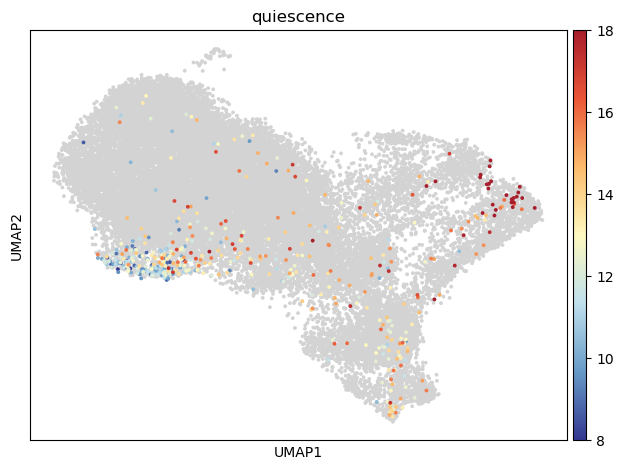

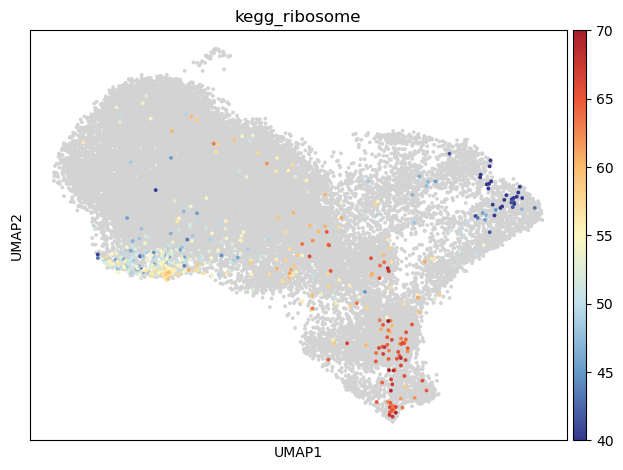

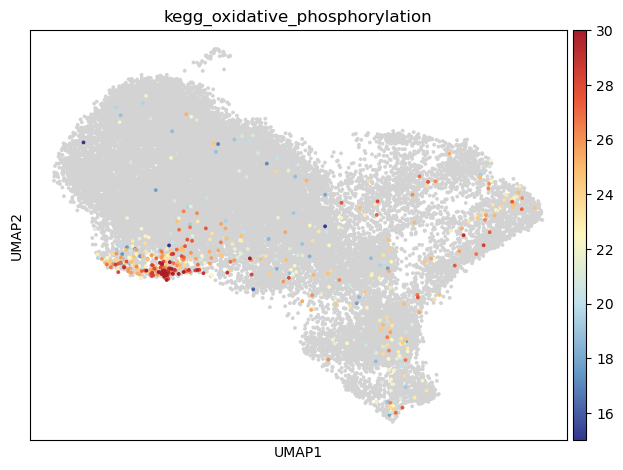

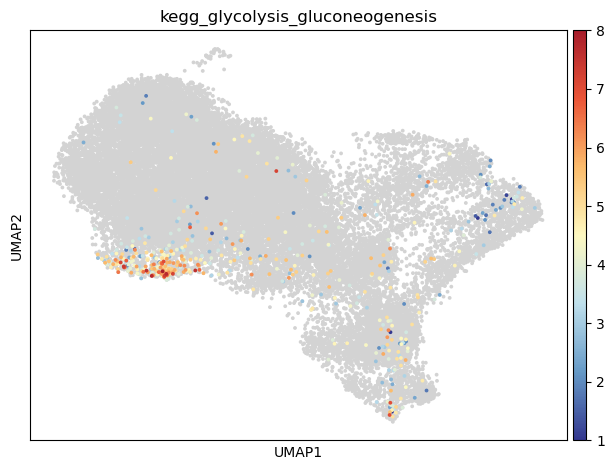

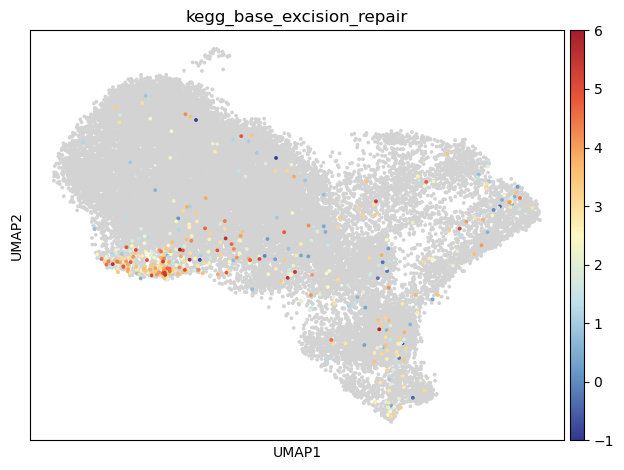

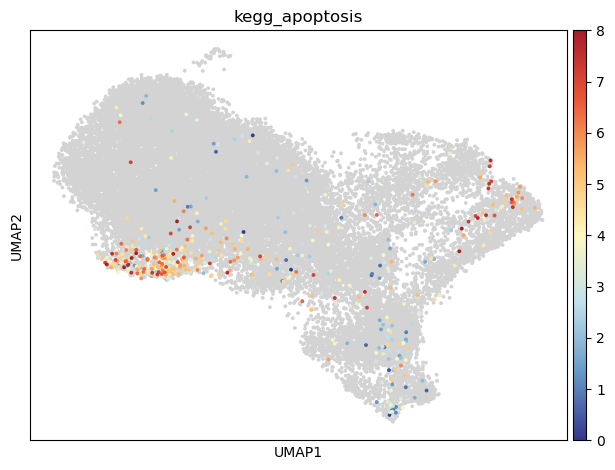

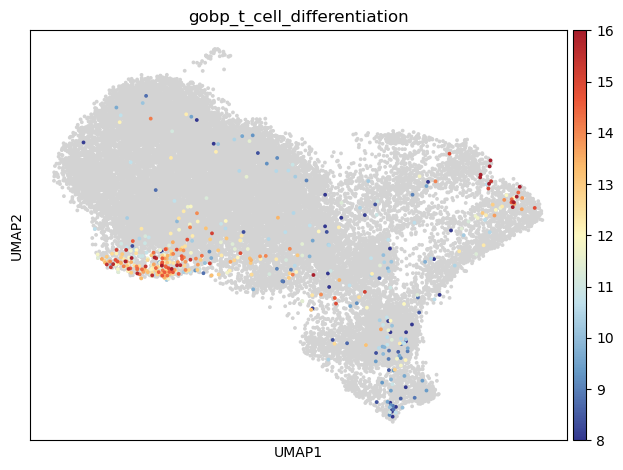

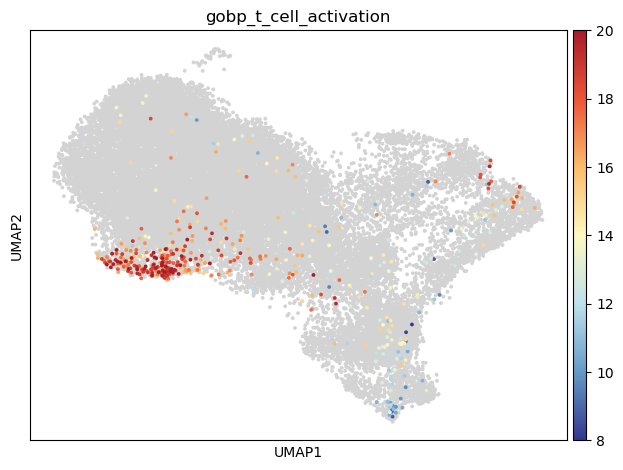

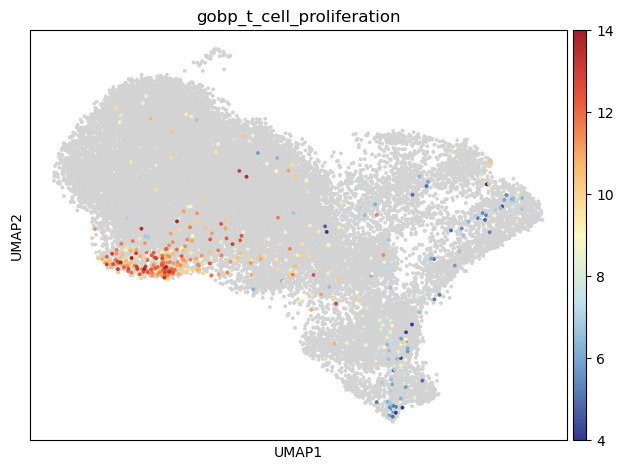

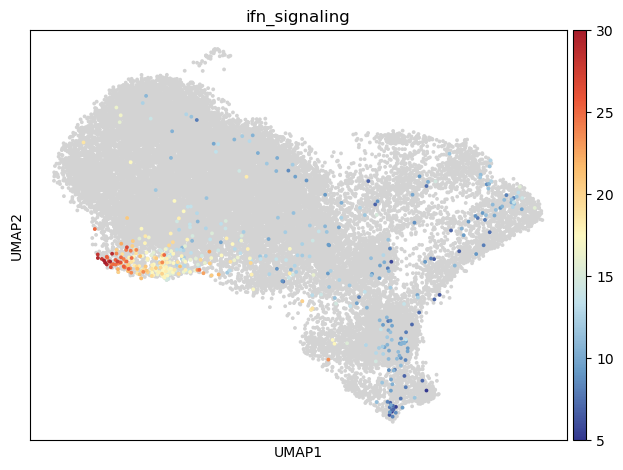

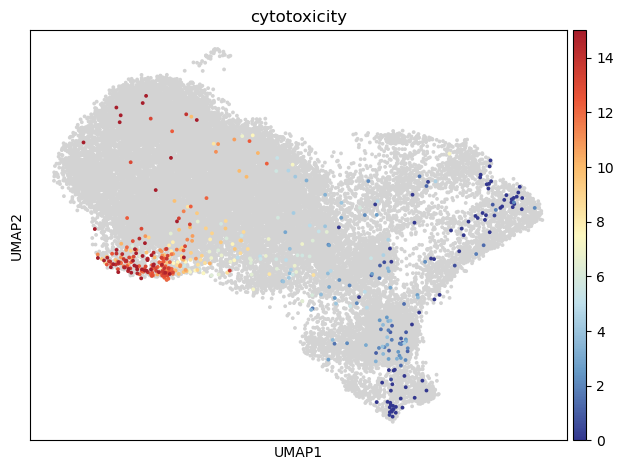

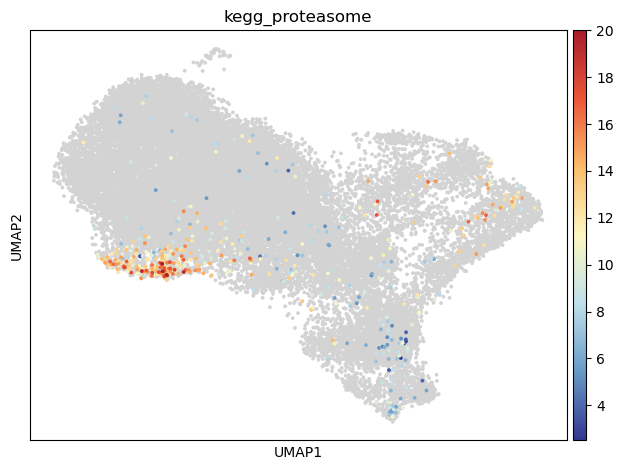

In [23]:
for i in pw.index:
    x = pw['vmax'][i]
    y = pw['vmin'][i]
    ax = sc.pl.umap(adata, cmap=cust, show=False, size=30)
    sc.pl.umap(adata[(adata.obs['specific_new']=='NS4B214')&(adata.obs['time'].isin(['d14']))], color=i, 
           cmap=cust_katha, show=False, size=30, ax=ax, vmax=x, vmin=y)
    plt.tight_layout()
    plt.savefig(f"{i}_UMAP_d14_all_specific_cells.pdf", dpi=300, bbox_inches='tight')
    plt.show()


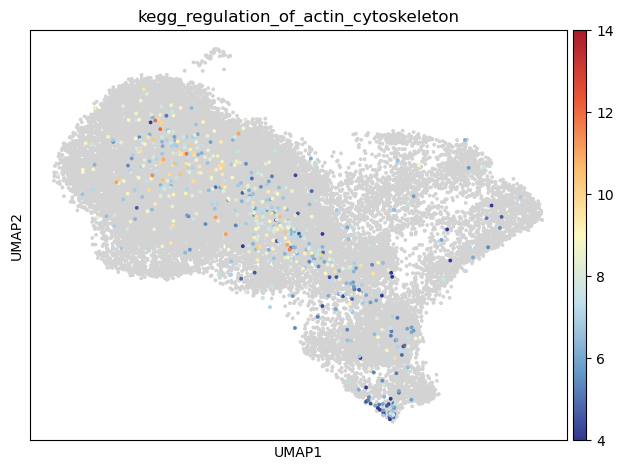

In [17]:
ax = sc.pl.umap(adata, cmap=cust, show=False, size=30)
sc.pl.umap(adata[(adata.obs['specific_new']=='NS4B214')&(adata.obs['time'].isin(['d365']))], color='kegg_regulation_of_actin_cytoskeleton', 
       cmap=cust_katha, show=False, size=30, ax=ax, vmax=14, vmin=4)
plt.tight_layout()
plt.savefig(f"kegg_regulation_of_actin_cytoskeleton_UMAP_d365_all_specific_cells.pdf", dpi=300, bbox_inches='tight')
plt.show()

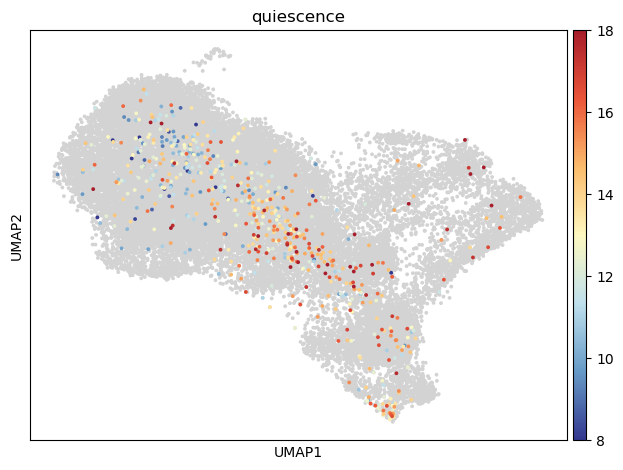

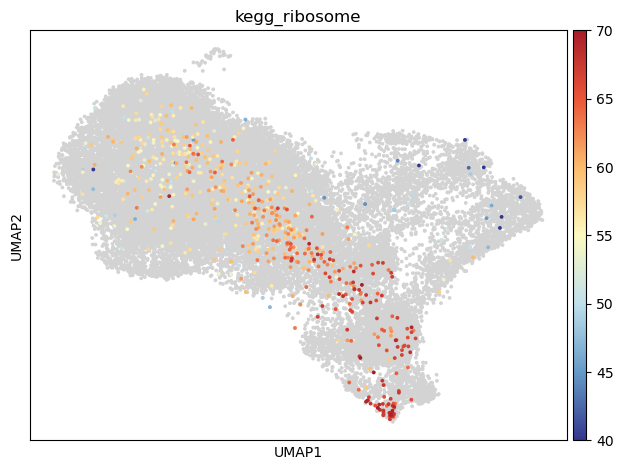

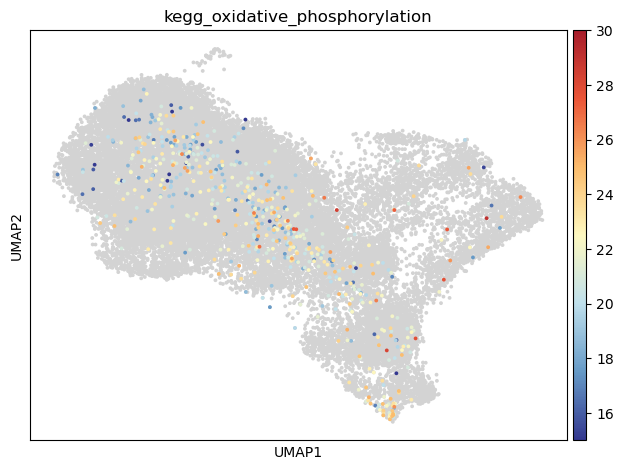

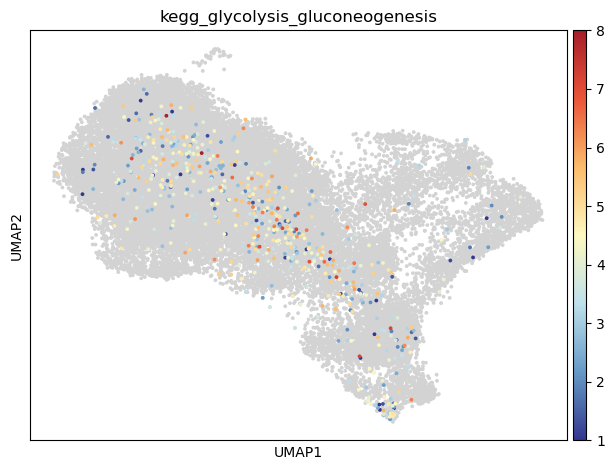

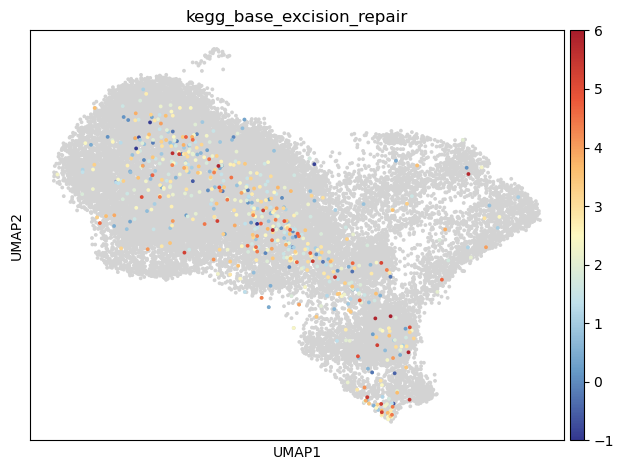

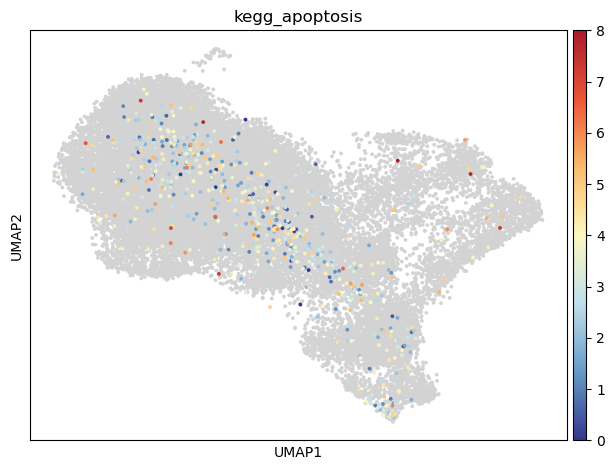

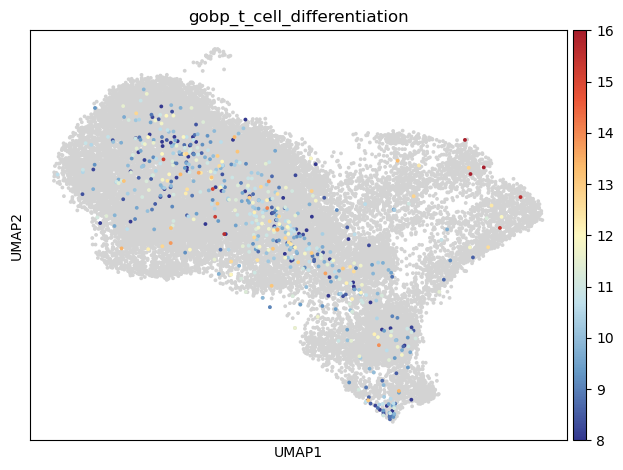

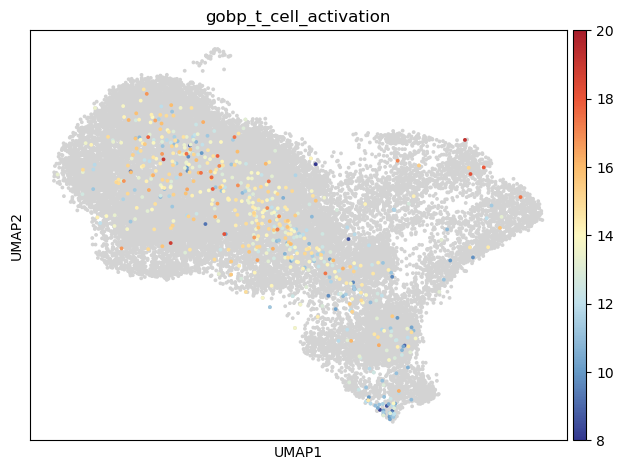

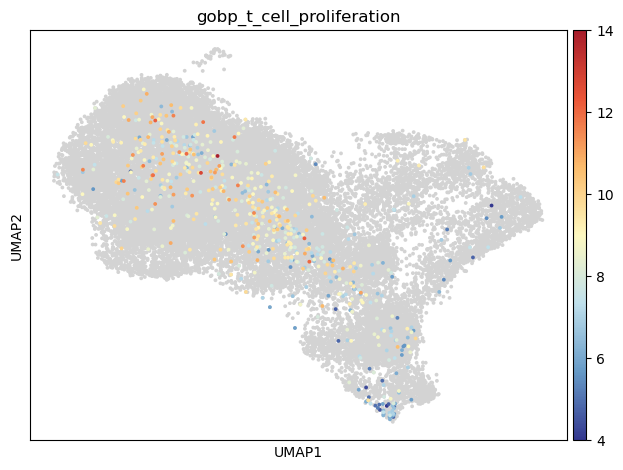

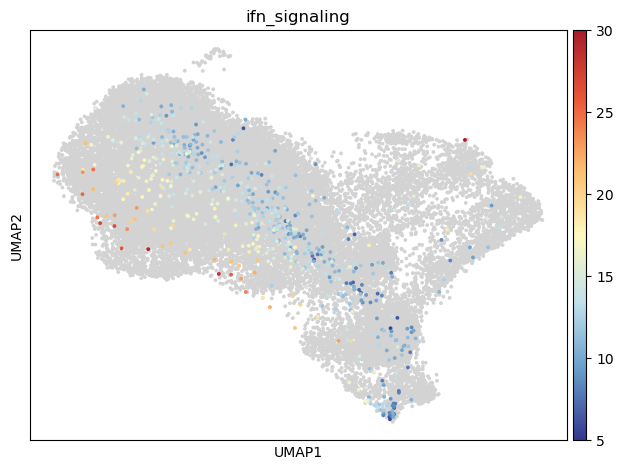

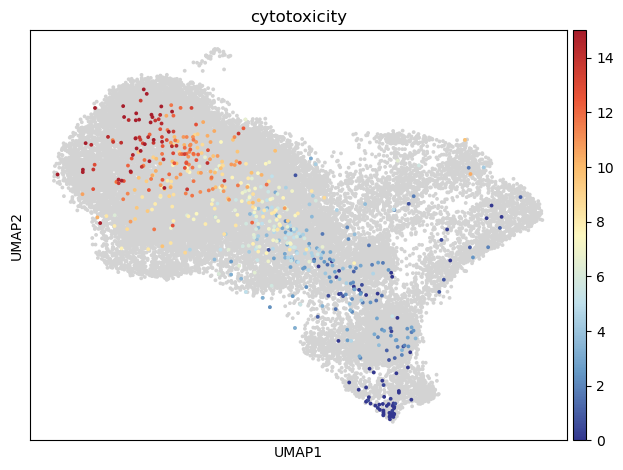

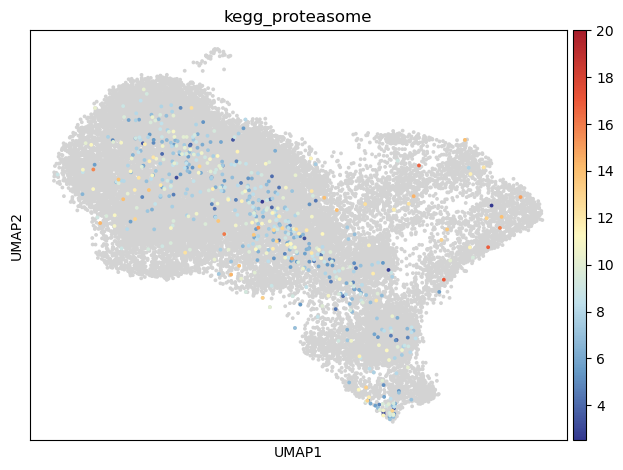

In [24]:
for i in pw.index:
    x = pw['vmax'][i]
    y = pw['vmin'][i]
    ax = sc.pl.umap(adata, cmap=cust, show=False, size=30)
    sc.pl.umap(adata[(adata.obs['specific_new']=='NS4B214')&(adata.obs['time'].isin(['d365']))], color=i, 
           cmap=cust_katha, show=False, size=30, ax=ax, vmax=x, vmin=y)
    plt.tight_layout()
    plt.savefig(f"{i}_UMAP_d365_all_specific_cells.pdf", dpi=300, bbox_inches='tight')
    plt.show()